<a href="https://colab.research.google.com/github/ahmrina/UNet-for-Brain-Tumor-Segmentation/blob/main/Preprocess_BraTS20_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing BraTS20 dataset

In [3]:
import os
from google.colab import drive
import random
import matplotlib.pyplot as plt
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
from tensorflow.keras.utils import to_categorical

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## download dataset from kaggle

In [3]:
path = '/content/drive/My Drive/MRI_segmentation_UNet'
os.makedirs(path, exist_ok=True)

In [4]:
!pip install kaggle

In [5]:
from google.colab import files
files.upload()

KeyboardInterrupt: 

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d "awsaf49/brats20-dataset-training-validation" -p "{path}"

In [ ]:
!unzip "{path}/brats20-dataset-training-validation.zip" -d "{path}"

## load as nib images

In [232]:
training_set = '/content/drive/My Drive/MRI_segmentation_UNet/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
validating_set = '/content/drive/My Drive/MRI_segmentation_UNet/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
# os.makedirs(dataset_path, exist_ok = True)

In [233]:
class load_BraTS20():
  def __init__(self):
    pass

  def load_nifti(self, file_path):
    img = nib.load(file_path)
    return img.get_fdata()

  def load_training(self, path, idx):

    patients = sorted(os.listdir(path))
    patient = patients[idx - 1]

    patient_dir = os.path.join(path, patient)
    if os.path.isdir(patient_dir):

        # t1_train = self.load_nifti(os.path.join(patient_dir, f'{patient}_t1.nii'))
        t1ce = self.load_nifti(os.path.join(patient_dir, f'{patient}_t1ce.nii'))
        t2 = self.load_nifti(os.path.join(patient_dir, f'{patient}_t2.nii'))
        flair = self.load_nifti(os.path.join(patient_dir, f'{patient}_flair.nii'))
        mask = self.load_nifti(os.path.join(patient_dir, f'{patient}_seg.nii'))
        print(f"LOADED: {patient_dir}")

            # return numpys

            # if t2_train.size == 0:
            #     t2_train = t2[None, ...]
            #     t1ce_train = t1ce[None, ...]
            #     flair_train = flair[None, ...]
            #     mask_train = mask[None, ...]
            # else:
            #   t1ce_train = np.concatenate((t1ce_train, t1ce[None, ...]), axis = 0)
            #   t2_train = np.concatenate((t2_train, t2[None, ...]), axis = 0)
            #   flair_train = np.concatenate((flair_train, flair[None, ...]), axis = 0)
            #   mask_train = np.concatenate((mask_train, mask[None, ...]), axis = 0)

    return t1ce, t2, flair, mask

  def load_validation(self, path, idx):
    # no segmentation masks
    patients = sorted(os.listdir(path))
    patient = patients[idx - 1]

    patient_dir = os.path.join(path, patient)
    if os.path.isdir(patient_dir):

        # t1_train = self.load_nifti(os.path.join(patient_dir, f'{patient}_t1.nii'))
        t1ce_val = self.load_nifti(os.path.join(patient_dir, f'{patient}_t1ce.nii'))
        t2_val = self.load_nifti(os.path.join(patient_dir, f'{patient}_t2.nii'))
        flair_val = self.load_nifti(os.path.join(patient_dir, f'{patient}_flair.nii'))
        print(patient_dir)

    return t1ce_val, t2_val, flair_val


In [343]:
dataset = load_BraTS20()

In [344]:
t1ce_train, t2_train, flair_train, mask_train = dataset.load_training(training_set, idx = 44)

LOADED: /content/drive/My Drive/MRI_segmentation_UNet/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_044


In [345]:
t1ce_train.shape, mask_train.shape

((240, 240, 155), (240, 240, 155))

## preprocessing methods

In [318]:
def normalize(img):
  """ dimensions expected: (240, 240, 155)
   returns normalized image with vals between 0 and 1"""
  x_p = (img - img.min()) / (img.max() - img.min())
  return x_p


def crop_image(img):
  """ dimensions expected: (240, 240, 155, 3)
  returns cropped image (128, 128, 128)"""
  if img.ndim == 4:
   return img[56:184, 56:184, 13:141, :]
  else:
    return img[56:184, 56:184, 13:141]
  print(f"cropped images shape: {img.shape}")


def fix_labels(patients):
  """ meant for masks only """
  for i in range(patients.shape[0]):
    patients[i] = np.where(patients[i] == 4, 3, patients[i])
  return patients


def plot_raw(t1ce: np, t2: np, flair: np, mask: np, titles = ["T1CE", "T2", "FLAIR", "mask"]):
  """ expects the raw image from dataset """
  rand_z = random.randint(0, t1ce.shape[2] - 1) # all have (240, 240, 155)
  fig, axs = plt.subplots(1, 4, figsize = (10, 5))
  print(f"Z dim: {rand_z}")
  axs[0].imshow(t1ce[:, :, rand_z])
  axs[0].axis('off')
  axs[0].set_title(f"channel {titles[0]}")
  axs[1].imshow(t2[:, :, rand_z])
  axs[1].axis('off')
  axs[1].set_title(f"channel {titles[1]}")
  axs[2].imshow(flair[:, :, rand_z])
  axs[2].axis('off')
  axs[2].set_title(f"channel {titles[2]}")
  axs[3].imshow(mask[:, :, rand_z])
  axs[3].axis('off')
  axs[3].set_title(f"{titles[3]}")
  plt.show()


def plot_random(img: np.array, mask: np.array, channels = 3): # channels = 0, 1, 2
  """expectes stacked image with channels """
  rand_z = random.randint(0, img.shape[2]-1)
  #rand_zm = random.randint(0, mask.shape[2]-1) #after preprocessing mask and image won't have the same number in dim Z
  titles = ["T1ce", "T2", "FLAIR"]
  print(f"Z dim: {rand_z}")
  fig, axs = plt.subplots(1, channels + 1, figsize = (10, 5)) # (channels + mask)

  for i in range(channels + 1):

    if i < channels:
        axs[i].imshow(img[:, :, rand_z, i])
        axs[i].axis('off')
        axs[i].set_title(f"channel {titles[i]}")

    if i >= channels:
      axs[i].imshow(mask[:, :, rand_z])
      axs[i].axis("off")
      axs[i].set_title("mask")

  plt.show()


def remove_blank_slices(img: np.array):
  """removes slices with pixels all black (0), for more efficient training and improving class weights imbalances"""
  # backwards iter
  for z in range(img.shape[2] - 1, -1, -1):

    if np.sum(img[:, :, z]) == 0:
      img = np.delete(img, z, axis=2)
      print(f"deleted slice {z}, new shape: {img.shape}")
  return img


def generate_name(name = "Brats2020Preprocessed_Training_", mask = "Brats2020Preprocessed_Mask_", n=0):
  return name + str(n) + ".npy", mask + str(n) + ".npy"


# def to_categorial(a):
#   """returns numpy array one hot encoded"""
#   num_classes = np.unique(a).shape[0]
#   ohe = np.zeros((a.shape[0], a.shape[1], a.shape[2], num_classes))

#   ohe[:, :, :, 0] = (a == 0)
#   ohe[:, :, :, 1] = (a == 1)
#   ohe[:, :, :, 2] = (a == 2)
#   ohe[:, :, :, 3] = (a == 3)
#   return ohe

## plotting raw image

Z dim: 16


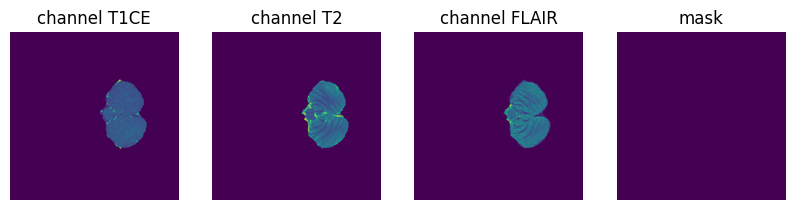

In [380]:
plot_raw(t1ce_train, t2_train, flair_train, mask_train)

## preprocessing and saving
- normalize images
- fix 4 to 3
- stack t1ce, t2, flair
- crop into (128x128x128)
- remove all 0 pixels volumes from mask (optional)
- to_categorical(mask)

## example: training sample 81

In [381]:
print(f"t1ce vals before normalizing: {np.min(t1ce_train), np.max(t1ce_train)}")
print(f"t2 vals before normalizing: {np.min(t2_train), np.max(t2_train)}")
print(f"flair vals before normalizing: {np.min(flair_train), np.max(flair_train)}")

t1ce vals before normalizing: (np.float64(0.0), np.float64(2734.0))
t2 vals before normalizing: (np.float64(0.0), np.float64(3240.0))
flair vals before normalizing: (np.float64(0.0), np.float64(1240.0))


In [382]:
normalized_t1ce = normalize(t1ce_train)
normalized_t2 = normalize(t2_train)
normalized_flair = normalize(flair_train)
print(f"t1ce vals after normalizing: {np.min(normalized_t1ce), np.max(normalized_t1ce)}")
print(f"t2 vals after normalizing: {np.min(normalized_t2), np.max(normalized_t2)}")
print(f"flair vals after normalizing: {np.min(normalized_flair), np.max(normalized_flair)}")

t1ce vals after normalizing: (np.float64(0.0), np.float64(1.0))
t2 vals after normalizing: (np.float64(0.0), np.float64(1.0))
flair vals after normalizing: (np.float64(0.0), np.float64(1.0))


In [383]:
#check labels before
np.unique(mask_train)

array([0., 1., 2., 4.])

In [384]:
mask = fix_labels(mask_train)
np.unique(mask)

array([0., 1., 2., 3.])

In [385]:
#stack channels
stacked = np.stack([normalized_t1ce, normalized_t2, normalized_flair], axis = 3)
print(stacked.shape)

(240, 240, 155, 3)


In [386]:
cropped, cropped_mask = crop_image(stacked), crop_image(mask)
print(cropped.shape, cropped_mask.shape)

(128, 128, 128, 3) (128, 128, 128)


Z dim: 109


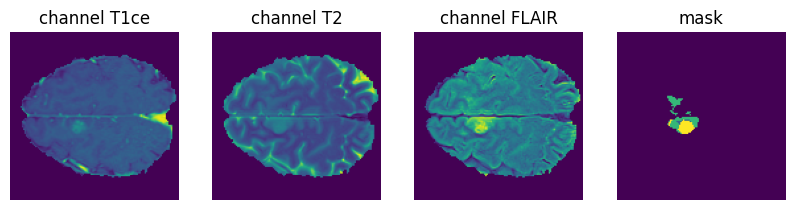

In [402]:
plot_random(cropped, cropped_mask)

In [403]:
ohe_mask = to_categorical(cropped_mask, num_classes=4)
np.unique(ohe_mask)

array([0., 1.])

In [404]:
save_path_img = "/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedImages"
save_path_mask = "/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedMasks"
img_name, mask_name = generate_name(n = 44)

img_full_path = os.path.join(save_path_img, img_name)
mask_full_path = os.path.join(save_path_mask, mask_name)

In [405]:
img_name, mask_name

('Brats2020Preprocessed_Training_44.npy', 'Brats2020Preprocessed_Mask_44.npy')

In [406]:
img_full_path, mask_full_path

('/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedImages/Brats2020Preprocessed_Training_44.npy',
 '/content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedMasks/Brats2020Preprocessed_Mask_44.npy')

In [407]:
vals, counts = np.unique(cropped_mask, return_counts = True)
print((1 - (counts[0] / counts.sum())))
print(f"vals: {vals}, counts: {counts}")
if ((1 - (counts[0] / counts.sum())) > 0.01):
   print((1 - (counts[0] / counts.sum())))
   print(f"saving {img_name, mask_name}")
   np.save(img_full_path, cropped)
   np.save(mask_full_path, ohe_mask)

0.009131431579589844
vals: [0. 1. 2. 3.], counts: [2078002     402   17336    1412]


In [408]:
np.save(img_full_path, cropped)
np.save(mask_full_path, ohe_mask)

In [28]:
from tqdm.auto import tqdm
num_patients = 370 # from 94 to 104

## preprocessing and saving
- stack t1ce, t2, flair
- fix 4 to 3
- normalize image
- crop into (128x128x128)
- remove all 0 volumes


  0%|          | 0/1 [00:00<?, ?it/s]

LOADED: /content/drive/My Drive/MRI_segmentation_UNet/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_369
Z dim: 55


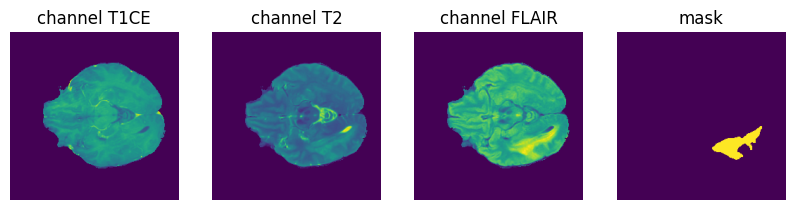

Z dim: 85


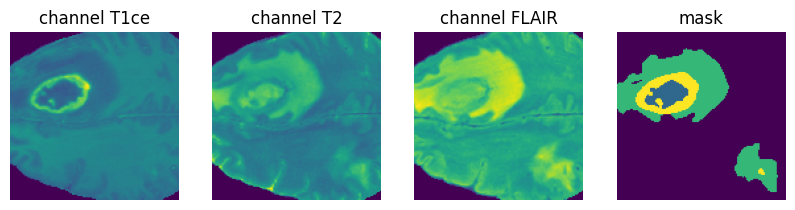

vals: [0. 1. 2. 3.], counts: [1885916   20589  148213   42434]
0.10072517395019531
saving Brats2020Preprocessed_Training_369.npy in /content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedImages/Brats2020Preprocessed_Training_369.npy
saving Brats2020Preprocessed_Mask_369.npy in /content/drive/MyDrive/MRI_segmentation_UNet/BraTS2020_PreprocessedMasks/Brats2020Preprocessed_Mask_369.npy


In [413]:
for index in tqdm(range(369, 370)):
  # I) load imgs
  t1ce_train, t2_train, flair_train, mask_train = dataset.load_training(training_set, index)

  plot_raw(t1ce_train, t2_train, flair_train, mask_train)

  # II) normalize channels
  normalized_t1ce_train = normalize(t1ce_train)
  normalized_t2_train = normalize(t2_train)
  normalized_flair_train = normalize(flair_train)

  # III) stack channels
  stacked = np.stack([normalized_t1ce_train, normalized_t2_train, normalized_flair_train], axis = 3)

  # IV) mask labels from [0, 1, 2, 4] -> [0, 1, 2, 3]
  mask = mask.astype(np.uint8)
  mask = fix_labels(mask_train)

  # crop into (3, 128, 128, 128) & (128, 128, 128)
  cropped, cropped_mask = crop_image(stacked), crop_image(mask)
  plot_random(cropped, cropped_mask)

  # one hot encoded mask
  ohe_mask = to_categorical(cropped_mask, num_classes=4)

  # save img
  img_name, mask_name = generate_name(n = index)
  img_full_path = os.path.join(save_path_img, img_name)
  mask_full_path = os.path.join(save_path_mask, mask_name)

  vals, counts = np.unique(cropped_mask, return_counts = True)
  print(f"vals: {vals}, counts: {counts}")
  if ((1 - (counts[0] / counts.sum())) > 0.01):
    print((1 - (counts[0] / counts.sum())))
    print(f"saving {img_name} in {img_full_path}")
    print(f"saving {mask_name} in {mask_full_path}")
    np.save(img_full_path, cropped)
    np.save(mask_full_path, ohe_mask)
